[1.         0.99993834 0.99987667 ... 0.09475175 0.10501585 0.11527995]


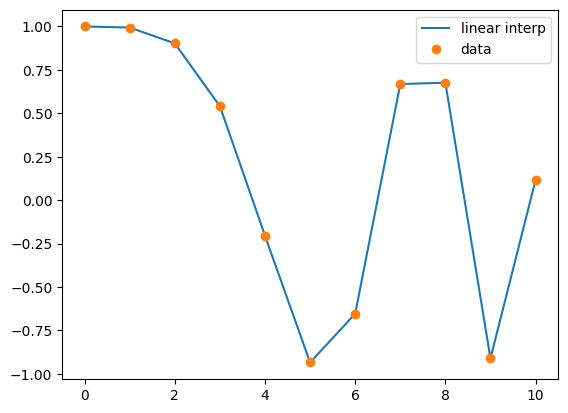

In [269]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, num=11)

y = np.cos(-x**2 / 9.0)

xnew = np.linspace(0, 10, num=1001)

ynew = np.interp(xnew, x, y)
print(ynew)


plt.plot(xnew, ynew, '-', label='linear interp')

plt.plot(x, y, 'o', label='data')

plt.legend(loc='best')

plt.show()


In [270]:
import json

with open('data/app/input-data.jsons', 'r') as datafile:
  line1 = datafile.readline()
  v = json.loads(line1)
  print(v)
  for [i, line] in enumerate(datafile.readlines()):
    with open(f'data/app/input-{i}.json', 'w') as wfile:
      wfile.write(line)



{'accelerometerData': [{'time': None, 'x': None, 'y': None, 'z': None, 'ms': None}], 'gyroscopeData': [{'time': None, 'x': None, 'y': None, 'z': None, 'ms': None}], 'gpsData': [{'time': None, 'latitude': None, 'longitude': None, 'accuracy': None, 'ms': None}, {'time': '2024-04-10T21:29:45.595159', 'latitude': 59.7248667, 'longitude': 30.5406517, 'accuracy': 3.9000000953674316, 'ms': None}]}


In [271]:
import pandas
import datetime

path = 'data/app/input-6.json'

def obj_set_time_to_int(obj):
  if (obj['time'] is not None):
    obj['time'] = int(datetime.datetime.fromisoformat(obj['time']).timestamp() * 1000000)
  return obj

with open(path) as file:
  data = json.loads(file.readline())
  accelerometerData = map(obj_set_time_to_int, data['accelerometerData'])
  gyroscopeData = map(obj_set_time_to_int, data['gyroscopeData'])
  gpsData = map(obj_set_time_to_int, data['gpsData'])

  acDf = pandas.DataFrame([o for o in accelerometerData])
  gyDf = pandas.DataFrame([o for o in gyroscopeData])
  gpsDf = pandas.DataFrame([o for o in gpsData])
  
  print(acDf, gyDf, gpsDf, sep='\n')
  print(acDf.dtypes, gyDf.dtypes, gpsDf.dtypes, sep='\n')

                 time      x      y      z  ms
0    1712773863632297 -0.106 -0.362 -0.227  38
1    1712773863653905 -0.059  0.347  0.054  20
2    1712773863673282  0.072 -0.030  0.484  20
3    1712773863708596  0.032  0.380 -0.664  35
4    1712773863733369 -0.135 -0.646 -0.108  24
..                ...    ...    ...    ...  ..
315  1712773878481441  0.475 -0.004  0.432  27
316  1712773878514009 -0.338 -0.249 -0.070  32
317  1712773878556055  0.176  0.464 -0.724  40
318  1712773878573868 -0.167 -1.053 -0.207  40
319  1712773878596430 -0.414  0.138 -0.222  22

[320 rows x 5 columns]
                 time         x         y         z  ms
0    1712773863632483 -0.066413  0.089787 -0.026400  38
1    1712773863660768  0.061875  0.054313 -0.011825  27
2    1712773863670577 -0.093363 -0.007975  0.005362  27
3    1712773863693931  0.080163 -0.056925  0.012650  23
4    1712773863727374 -0.065175 -0.100787 -0.011825  33
..                ...       ...       ...       ...  ..
319  171277387847409

In [272]:
acDfc = acDf[acDf.ms.notna()]
gyDfc = gyDf[gyDf.ms.notna()]
gpsDfc = gpsDf[gpsDf.ms.notna()]

print(acDfc, gyDfc, gpsDfc, sep='\n')

                 time      x      y      z  ms
0    1712773863632297 -0.106 -0.362 -0.227  38
1    1712773863653905 -0.059  0.347  0.054  20
2    1712773863673282  0.072 -0.030  0.484  20
3    1712773863708596  0.032  0.380 -0.664  35
4    1712773863733369 -0.135 -0.646 -0.108  24
..                ...    ...    ...    ...  ..
315  1712773878481441  0.475 -0.004  0.432  27
316  1712773878514009 -0.338 -0.249 -0.070  32
317  1712773878556055  0.176  0.464 -0.724  40
318  1712773878573868 -0.167 -1.053 -0.207  40
319  1712773878596430 -0.414  0.138 -0.222  22

[320 rows x 5 columns]
                 time         x         y         z  ms
0    1712773863632483 -0.066413  0.089787 -0.026400  38
1    1712773863660768  0.061875  0.054313 -0.011825  27
2    1712773863670577 -0.093363 -0.007975  0.005362  27
3    1712773863693931  0.080163 -0.056925  0.012650  23
4    1712773863727374 -0.065175 -0.100787 -0.011825  33
..                ...       ...       ...       ...  ..
319  171277387847409

In [273]:
import src.processing as processing
import pandas
import numpy
from scipy.signal import lfilter, iirfilter

tick = 25000
window = 128
slide = 0.5
fs = 1000000 / tick
filter_N = 2
filter_freq = 10

def reduce_noice(acDf: pandas.DataFrame, gyDf: pandas.DataFrame):
    b, a = iirfilter(filter_N, Wn=filter_freq, fs=fs, btype="low", ftype="butter")

    acX = lfilter(b, a, acDf.x)
    acY = lfilter(b, a, acDf.y)
    acZ = lfilter(b, a, acDf.z)

    gyX = lfilter(b, a, gyDf.x)
    gyY = lfilter(b, a, gyDf.y)
    gyZ = lfilter(b, a, gyDf.z)

    acDf1 = pandas.DataFrame({"time": acDf.time, "x": acX, "y": acY, "z": acZ})
    gyDf1 = pandas.DataFrame({"time": gyDf.time, "x": gyX, "y": gyY, "z": gyZ})

    return (acDf1, gyDf1)
    # acil = (acXil**2 + acYil**2 + acZil**2) ** 0.5
    # gyil = (gyXil**2 + gyYil**2 + gyZil**2) ** 0.5


(acDfn, gyDfn) = reduce_noice(acDfc, gyDfc)
(acDfi, gyDfi, gpsDfi) = processing.interpolate(acDfn, gyDfn, gpsDfc)

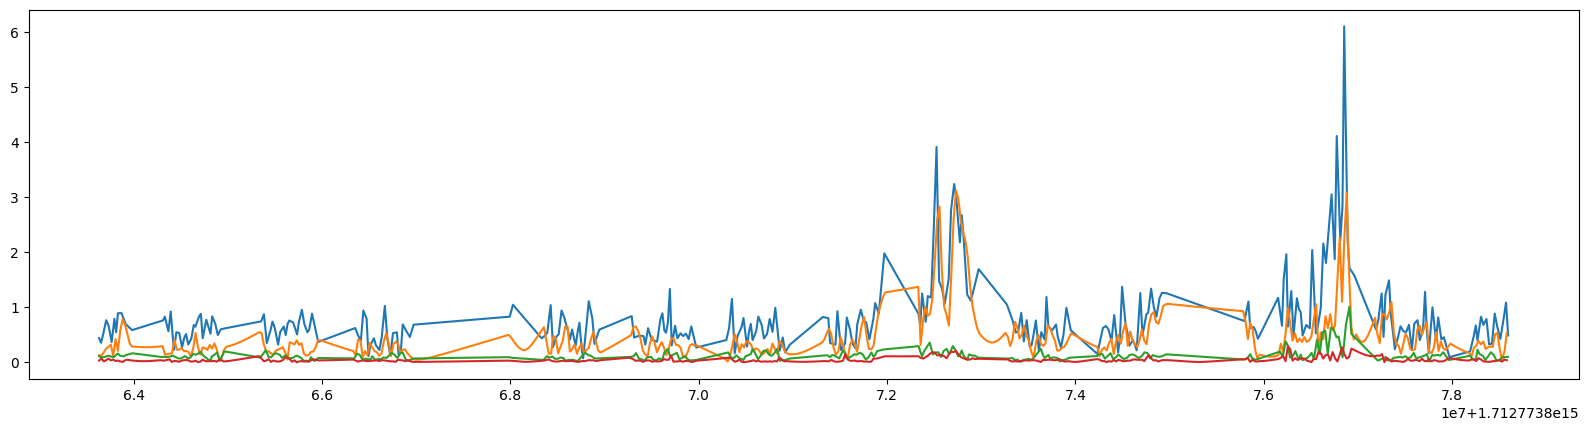

In [274]:
# initial values
acTimes = acDfc.time.to_numpy()
acX = acDfc.x.to_numpy()
acY = acDfc.y.to_numpy()
acZ = acDfc.z.to_numpy()

ac = (acX ** 2 + acY ** 2 + acZ ** 2) ** 0.5

gyTimes = gyDfc.time.to_numpy()
gyX = gyDfc.x.to_numpy()
gyY = gyDfc.y.to_numpy()
gyZ = gyDfc.z.to_numpy()

gy = (gyX ** 2 + gyY ** 2 + gyZ ** 2) ** 0.5


# processed values
acTimesi = acDfi.time.to_numpy()
acXi = acDfi.x.to_numpy()
acYi = acDfi.y.to_numpy()
acZi = acDfi.z.to_numpy()

aci = (acXi ** 2 + acYi ** 2 + acZi ** 2) ** 0.5

gyTimesi = gyDfi.time.to_numpy()
gyXi = gyDfi.x.to_numpy()
gyYi = gyDfi.y.to_numpy()
gyZi = gyDfi.z.to_numpy()

gyi = (gyXi ** 2 + gyYi ** 2 + gyZi ** 2) ** 0.5

plt.figure().set_figwidth(20)
plt.plot(acTimes, ac, '-')
plt.plot(acTimesi, aci, '-')

plt.plot(gyTimes, gy, '-')
plt.plot(gyTimesi, gyi, '-')